In [364]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join as pjoin
from tqdm import tqdm

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [365]:
from utils import *
from viz import *

# Hyperparameters

## EDA

In [679]:
PLOT = False

## PREPROCESSING

In [826]:
USE_LOW_PASS_FILTER = False
ROLLING_WINDOW = 32

DOWNSAMPLE = False
DOWNSAMPLE_WINDOW = 4

## ML

# Get the data

In [827]:
data_folder = pjoin("data", "MixedShapesRegularTrain")
train_fname = "MixedShapesRegularTrain_TRAIN.tsv"
test_fname = "MixedShapesRegularTrain_TEST.tsv"

train_data = pd.read_csv(pjoin(data_folder, train_fname), sep='\t')

# EDA

In [828]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Columns: 1025 entries, 1 to 1.1120469
dtypes: float64(1024), int64(1)
memory usage: 3.9 MB


In [829]:
train_data.head()

,1,1.1309687,1.1204832,1.1077719,1.0424568,0.96409116,0.91385703,0.9255513,0.90369937,0.91716544,...,0.67574464,0.66714198,0.75205753,0.82026784,0.8957213,0.9829251,1.0491094,1.0931087,1.1025334,1.1120469
0,1,0.830904,0.815222,0.803198,0.742477,0.683805,0.672666,0.673233,0.679851,0.664352,...,0.545351,0.540754,0.603622,0.650685,0.708652,0.771576,0.791044,0.816584,0.819874,0.823568
1,1,0.816833,0.810941,0.772436,0.734036,0.695747,0.657560,0.617705,0.579676,0.541709,...,0.677791,0.709058,0.710436,0.729174,0.743558,0.785415,0.802844,0.805283,0.807960,0.810870
2,1,1.942775,1.928545,1.903324,1.879062,1.812798,1.746591,1.675465,1.611625,1.548000,...,1.660595,1.701224,1.748952,1.794030,1.845204,1.864267,1.860472,1.909628,1.958690,1.944351
3,1,1.873812,1.863549,1.814253,1.779266,1.766919,1.735888,1.675732,1.699785,1.720428,...,1.818965,1.854731,1.890964,1.918501,1.903307,1.910518,1.895921,1.881597,1.873381,1.898326
4,1,2.314335,2.302548,2.283370,2.246295,2.189444,2.150547,2.092030,2.038564,2.015111,...,1.970946,2.020198,2.072746,2.123032,2.172533,2.219684,2.267653,2.315809,2.317153,2.329100


In [830]:
#TODO: should I sort the column names?

**Conclusion: the features and the labels can be seperated by the column dtype**

In [831]:
# splitting the dataset to its features and labels
features = train_data.select_dtypes(include=['float64'])
labels = train_data.select_dtypes(include=['int64'])


In [832]:
# get the labels column name
print(labels.columns)

Index(['1'], dtype='object')


In [833]:
if PLOT:
    # get labels stats
    plt.figure(figsize=(15,3))
    ax = sns.countplot(y="1", data=labels)

    for p in ax.patches:
        ax.annotate(f'{p.get_width()}', (p.get_width()+1, p.get_y()+0.5))

**Conclusion: balanced dataset**

### Something with the column names doesn't make sense. maybe it should be sorted?

In [834]:
y = features.columns.astype("float")
x = np.arange(len(y))

In [835]:
if PLOT:
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    axes[0].plot(x,y)
    axes[1].plot(x,sorted(y))

    axes[0].set_title("Original columns order")
    axes[1].set_title("Sorted columns order")

**Conclusion: Maybe it should be sorted... I should read the papers refferd to in the README.md file to better understand**

## Visualuziation

In [836]:
NUM_SAMPLES_PER_CLASS = 10

In [837]:
if PLOT:
    samples = visualize_dataset(train_data, NUM_SAMPLES_PER_CLASS)

**Conclusion: looks like a clustering \ knn algorithm will be usefull. I've noticed that some classes (e.g. 1) might have multiple sub-clusters**
**Conclusion: looks like a low pass filtering would be usefull**

In [838]:
if PLOT:
    rolling_dataset = pd.concat([labels, features.rolling(ROLLING_WINDOW, axis=1).mean()], axis=1)
    rolling_dataset = rolling_dataset.dropna(axis=1)
    rolling_samples = visualize_dataset(rolling_dataset, NUM_SAMPLES_PER_CLASS)

## Data Cleaning

In [839]:
# any dupplicates?
features.duplicated().any()

False

**Conclusion: No**

In [840]:
# any missing values?
features.isna().sum().sum()

0

**Conclusion: No**

In [841]:
# Low pass filtering
if USE_LOW_PASS_FILTER:
    features = features.rolling(ROLLING_WINDOW, axis=1).mean()
    features = features.dropna(axis=1)
    
features.shape

(499, 1024)

In [842]:
# downsampling
if DOWNSAMPLE:
    features = features.rolling(DOWNSAMPLE_WINDOW, axis=1).mean()
    features = features[features.columns[DOWNSAMPLE_WINDOW-1::DOWNSAMPLE_WINDOW]]
    
features.shape

(499, 1024)

In [843]:
if PLOT:
    samples = visualize_dataset(pd.concat([labels, features], axis=1), NUM_SAMPLES_PER_CLASS)

## Remove outliers

# Data splitting

In [764]:
from sklearn.model_selection import train_test_split

In [765]:
#TODO: do a kfold cross validation split


In [766]:
# splitting to train, val, test
X_train, X_test, y_train, y_test = train_test_split(features, labels, stratify=labels, test_size=0.1)#, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.22)#, random_state=1)


print("Train: ", np.unique(y_train, return_counts = True))
print("Val: ", np.unique(y_val, return_counts = True))
print("Test: ", np.unique(y_test, return_counts = True))

Train:  (array([1, 2, 3, 4, 5], dtype=int64), array([70, 70, 70, 70, 70], dtype=int64))
Val:  (array([1, 2, 3, 4, 5], dtype=int64), array([19, 20, 20, 20, 20], dtype=int64))
Test:  (array([1, 2, 3, 4, 5], dtype=int64), array([10, 10, 10, 10, 10], dtype=int64))


# Preprocessing

**Conclusion: all sequences have the same length, therefore there is no need for special care in this aspect**

In [ ]:
#label encoding
# no need for a LabelEncoder(), just substruct 1 from the labels to have it 0-based.

# Feature extraction

# Modeling

## Experiment #1: KNN with DTW

* _

## Testing the DTW metric

In [17]:
from dtaidistance import dtw
# from fastdtw import fastdtw
# from scipy.spatial.distance import euclidean

In [236]:
dists = [ [ None ]*len(class_names) ]*len(class_names)

# for i in tqdm(range(len(class_names))):
for i in range(len(class_names)):

    for j in range(i, len(class_names)):
        cls_x = X_train.loc[y_train["1"]==class_names[i]]
        cls_y = X_train.loc[y_train["1"]==class_names[j]]
        dists[i][j] = [dtw.distance_fast(cls_x.iloc[x].values, cls_y.iloc[y].values) for x in range(5) for y in range(5)]
#         for x in range(5):
#             for y in range(5):
#                 s1 = cls_x.iloc[x].values
#                 s2 = cls_y.iloc[y].values
#                 print(i,j,x,y)
#                 dists[i][j].append(dtw.distance_fast(s1, s2))


In [ ]:
fig, axes = plt.subplots(len(class_names), len(class_names), figsize=(15,10), sharey=True)

for i in range(len(dists)):
    for j in range(i, len(dists)):
        sns.distplot(x=dists[i][j], ax=axes[i][j])
        if i==0:
            axes[i][j].set_title(f"Class: {cls}")
    

plt.tight_layout()

In [122]:
dists3 = np.zeros((len(cls1),len(cls1)))
for i in tqdm(range(len(cls2))):
    for j in range(len(cls2)):
        s1 = cls2.iloc[i].values
        s2 = cls2.iloc[j].values
        dists3[i,j] = dtw.distance_fast(s1, s2)
# sns.distplot(dists3)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:23<00:00,  3.00it/s]


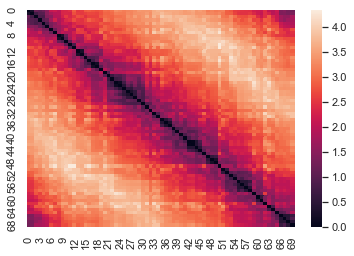

In [121]:
sns.heatmap(dists3)

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [23]:
# nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree', metric=dtw.distance_fast)
cls = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree', metric=dtw.distance_fast)
cls.fit(X_train, y_train["1"])
y_pred = cls.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

KeyboardInterrupt: 

In [ ]:
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

In [258]:
cls = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree', metric=dtw.distance_fast)

In [ ]:
# cv_scores = cross_val_score(cls, 
#                             features, 
#                             labels["1"], 
#                             cv=5, # integer, to specify the number of folds in a (Stratified)KFold,
#                             scoring="f1_weighted",
#                             n_jobs=-1,
#                            )
# cv_scores

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
grid_params = {
    "n_neighbors": [1,3,5,7,9],
    "weights": ["uniform", "distance"],
    "metric": [dtw.distance_fast, "minkowski"]
}

knn_gs = GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    verbose=1,
    cv=5,
    n_jobs=-1,
)

In [27]:
knn_gs_results = gs.fit(features, labels["1"])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 35.3min finished


In [29]:
print("best_score: ", knn_gs_results.best_score_)
print("best_estimator_: ", knn_gs_results.best_estimator_)
print("best_params_: ", knn_gs_results.best_params_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [37]:
from sklearn.preprocessing import MinMaxScaler

In [38]:
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)


In [39]:
knn_gs_results_scaled = knn_gs.fit(features, labels["1"])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 35.1min finished


best_score:  0.8977979797979799
best_estimator_:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')
best_params_:  {'metric': 'minkowski', 'n_neighbors': 1, 'weights': 'uniform'}


## Experiment #2: Feature extraction with DWT + classic ML classifier

In [698]:
import pywt

In [699]:
# CWT + CNN
# scales = np.arange(1,128)
# waveletname = 'mexh'
# sample = features.iloc[400]
# time = np.arange(len(sample.index))
# signal = sample.values
# plot_wavelet(time, signal, scales, waveletname=waveletname)

In [904]:
DECONSTRUCT_LEVEL = 3

coeffs = pywt.wavedec(signal, 'db2', level=DECONSTRUCT_LEVEL)
nth_level_approx_coeffs = coeffs[0]
nth_level_approx_coeffs.shape

(33,)

In [905]:
cwt_features = []
for i, row in features.iterrows():
    coeffs = pywt.wavedec(row, 'db2', level=DECONSTRUCT_LEVEL)
    nth_level_approx_coeffs = coeffs[0]
    cwt_features.append(nth_level_approx_coeffs)
    
cwt_features = pd.DataFrame(cwt_features, index=features.index)

In [912]:
grid_params = {
    "max_depth": list(range(2,32,2)),
}

rf_gs = GridSearchCV(
    RandomForestClassifier(),
    grid_params,
    verbose=1,
    cv=5,
    n_jobs=-1,
)

In [913]:
rf_gs_results = rf_gs.fit(cwt_features, labels["1"])

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    4.0s finished


In [914]:
print("best_score: ", rf_gs_results.best_score_)
print("best_estimator_: ", rf_gs_results.best_estimator_)
print("best_params_: ", rf_gs_results.best_params_)

best_score:  0.8917979797979798
best_estimator_:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
best_params_:  {'max_depth': 30}


In [894]:
from sklearn import preprocessing
from sklearn.decomposition import PCA


In [899]:
cwt_features_scaled = preprocessing.scale(cwt_features)
# cwt_features_scaled = cwt_features - cwt_features.mean()


In [900]:
pca = PCA(n_components=2)
pca.fit(cwt_features_scaled)
X = pca.transform(cwt_features_scaled)

In [901]:
cls1 = X[np.where(labels["1"]==1)[0]]
cls2 = X[np.where(labels["1"]==2)[0]]
cls3 = X[np.where(labels["1"]==3)[0]]
cls4 = X[np.where(labels["1"]==4)[0]]
cls5 = X[np.where(labels["1"]==5)[0]]

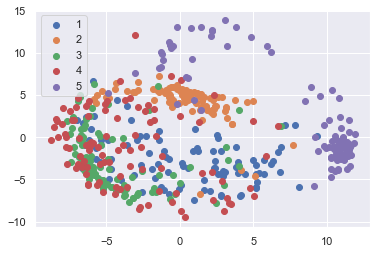

In [920]:
plt.scatter(cls1[:, 0], cls1[:, 1], label=1)
plt.scatter(cls2[:, 0], cls2[:, 1], label=2)
plt.scatter(cls3[:, 0], cls3[:, 1], label=3)
plt.scatter(cls4[:, 0], cls4[:, 1], label=4)
plt.scatter(cls5[:, 0], cls5[:, 1], label=5)
plt.legend()

In [656]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(cwt_features, labels_1["1"], stratify=labels, test_size=0.2)#, random_state=1)

In [678]:
labels_1 = labels-1

xgb_model = xgb.XGBClassifier()

D_train = xgb.DMatrix(X_train, label=y_train)
D_val = xgb.DMatrix(X_val, label=y_val)

param = {
    'eta': 0.3, 
    'max_depth': 8,  
    'objective': 'multi:softprob',  
    'num_class': 5} 

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

steps = 20  # The number of training iterations

model = xgb.train(param, D_train, steps)

y_pred = model.predict(D_val)
best_preds = np.asarray([np.argmax(line) for line in y_pred])

print(classification_report(y_val, best_preds))
print(confusion_matrix(y_val, best_preds))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        20
           1       0.95      0.90      0.92        20
           2       0.75      0.75      0.75        20
           3       0.70      0.80      0.74        20
           4       0.94      0.85      0.89        20

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100

[[16  0  2  2  0]
 [ 1 18  0  1  0]
 [ 2  0 15  2  1]
 [ 1  1  2 16  0]
 [ 0  0  1  2 17]]


## Experiment #3: Deep LSTM + FC classifier